In [2]:
''' Import libraries '''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from tqdm import tqdm
from IPython.display import display
from utils import *
import warnings
warnings.filterwarnings("ignore")

In [3]:
def true_function_easy(x, dimension):

    term1 = 0.
    term2 = 0.
    for i in range(dimension):
        term1 += (x[i] - 5)**2
        term2 += x[i]**2

    return -1*(1/dimension * term1 + np.exp(-term2)) + 25

# Dataframe with bounds
bounds = pd.read_csv('data/ART/sim_data_bounds_FE.csv')

In [13]:
df_A = pd.read_csv('data/ART/sim_data_FE_cycle2.csv')
df_B = pd.read_csv('data/ART/sim_data_FE_cycle3.csv')
df_C = pd.read_csv('data/ART/sim_data_FE_cycle4.csv')

print(f'Shape of df_A: {df_A.shape}')
print(f'Shape of df_B: {df_B.shape}')
print(f'Shape of df_C: {df_C.shape}')

def transform_data(df: pd.DataFrame) -> pd.DataFrame:
    ''' Get data to the right format for analysis '''
    new_columns = df['Type'].unique()
    data = pd.DataFrame()
    data.index = df['Line Name'].unique()
    # add new columns to data
    for col in new_columns:
        data[col] = 0
    # fill in data
    for l in data.index:
        for c in new_columns:
            value = df[(df['Line Name'] == l) & (df['Type'] == c)]['0.0'].values
            data.loc[l, c] = value
    return data

data_A = transform_data(df_A)
data_B = transform_data(df_B)
data_C = transform_data(df_C)

# From data_B and data_C keep only last 16 rows
data_B = data_B.iloc[-16:, :]
data_C = data_C.iloc[-16:, :]

print(f'Shape of data_A: {data_A.shape}')
print(f'Shape of data_B: {data_B.shape}')
print(f'Shape of data_C: {data_C.shape}')

data_A.head()

Shape of df_A: (1100, 3)
Shape of df_B: (1276, 3)
Shape of df_C: (1452, 3)
Shape of data_A: (100, 11)
Shape of data_B: (16, 11)
Shape of data_C: (16, 11)


,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,y
0,5.907208,6.576535,-0.242593,6.114163,-2.848603,1.849267,6.197468,4.918893,0.769597,-2.737659,6.722950
1,2.698782,-4.462857,0.685362,7.962224,8.781270,-0.858752,-1.477080,0.786529,9.343848,4.727586,0.049574
2,-0.741186,9.877792,-1.024809,-3.203699,2.233067,5.918829,3.916316,9.039919,9.183203,6.209341,4.468977
3,-1.900750,-0.348457,9.710673,9.015978,-1.224394,0.290745,0.948808,5.219646,1.273533,1.707213,3.334556
4,5.950167,2.942013,5.725042,-3.159716,-3.227454,6.237760,9.783681,4.054161,4.061268,3.124453,8.035507


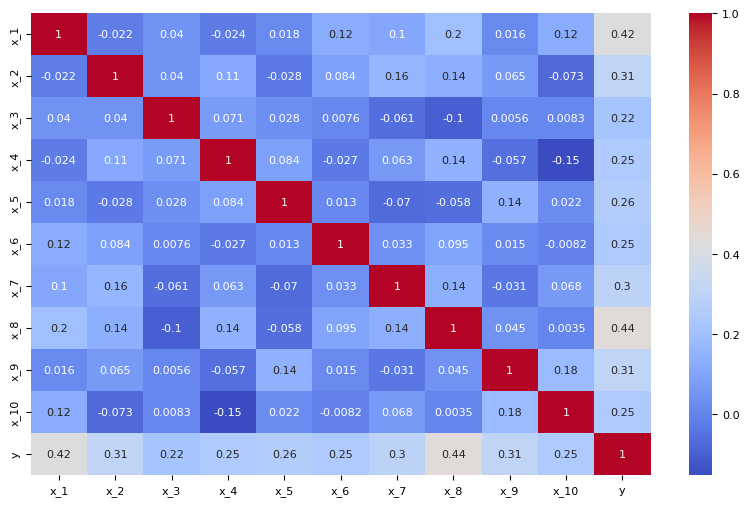

In [14]:
''' Correlations heatmap '''
corr = data_A.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

DBTL 1st cycle


,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,y
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2.492894,2.492192,2.499529,2.502866,2.501900,2.502399,2.496490,2.499456,2.497914,2.499819,0.004312
std,4.351912,4.351603,4.350057,4.349624,4.355801,4.350824,4.354209,4.346480,4.347048,4.348387,9.081025
min,-4.913495,-4.989912,-4.985762,-4.850166,-4.951004,-4.887772,-4.879000,-4.871297,-4.850356,-4.963776,-19.897955
25%,-1.167267,-1.192006,-1.208674,-1.176848,-1.250809,-1.255551,-1.258706,-1.230931,-1.213935,-1.195914,-7.083475
50%,2.518591,2.513777,2.493275,2.544437,2.475972,2.543178,2.523137,2.474540,2.510605,2.508500,1.345574
75%,6.229358,6.180490,6.152641,6.174827,6.244418,6.250363,6.211085,6.169398,6.214646,6.255417,7.182208
max,9.856610,9.877792,9.931191,9.946836,9.856838,9.991896,9.976325,9.894492,9.861578,9.875483,17.218924


DBTL 2nd cycle


,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,y
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000
mean,4.878717,5.426043,4.562629,4.240355,5.319787,5.213944,4.593124,4.909415,4.916693,5.494882,22.375089
std,1.324943,1.920702,1.785308,1.313381,1.867567,1.753954,1.632026,0.960200,1.836555,1.574431,0.490556
min,3.026435,2.499850,0.812890,2.138053,1.593527,2.015163,1.539094,2.725101,1.687204,2.385368,21.590856
25%,4.095557,3.737993,3.725812,3.369494,4.182732,3.815594,3.937048,4.503515,3.815874,4.194588,22.101230
50%,4.562973,5.318182,4.821200,4.038978,5.728282,5.727683,4.570595,5.026425,5.329445,5.751208,22.414802
75%,5.712264,7.040570,5.338912,4.984571,6.769793,6.434329,5.740422,5.239849,6.382458,6.491926,22.848984
max,7.220851,8.006332,8.231733,6.701664,8.057984,8.228838,7.128681,7.408791,7.297742,8.177607,22.965737


DBTL 3nd cycle


,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,y
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000
mean,5.039083,5.191129,5.125282,4.677884,5.091928,4.865806,4.866883,5.460318,5.532003,4.770489,23.961452
std,1.300325,0.751114,0.923419,0.965946,1.002856,0.825003,0.934727,0.981345,1.074244,1.249291,0.148593
min,2.892308,4.090545,3.504112,3.411547,3.790316,3.577096,3.336893,3.453670,3.794478,2.771586,23.808507
25%,4.144772,4.626686,4.544650,3.896079,4.310035,4.280909,4.150237,4.895357,4.862776,3.953552,23.836716
50%,5.027176,5.132717,5.410308,4.548133,4.888893,4.839860,4.828065,5.281942,5.538714,4.285760,23.911207
75%,6.076005,5.537906,5.689350,5.081531,5.736343,5.338639,5.555899,6.334625,6.355002,5.545394,24.072366
max,7.049882,6.520730,6.358142,6.552833,7.245222,6.305235,6.320137,6.774185,7.404642,7.188898,24.250769


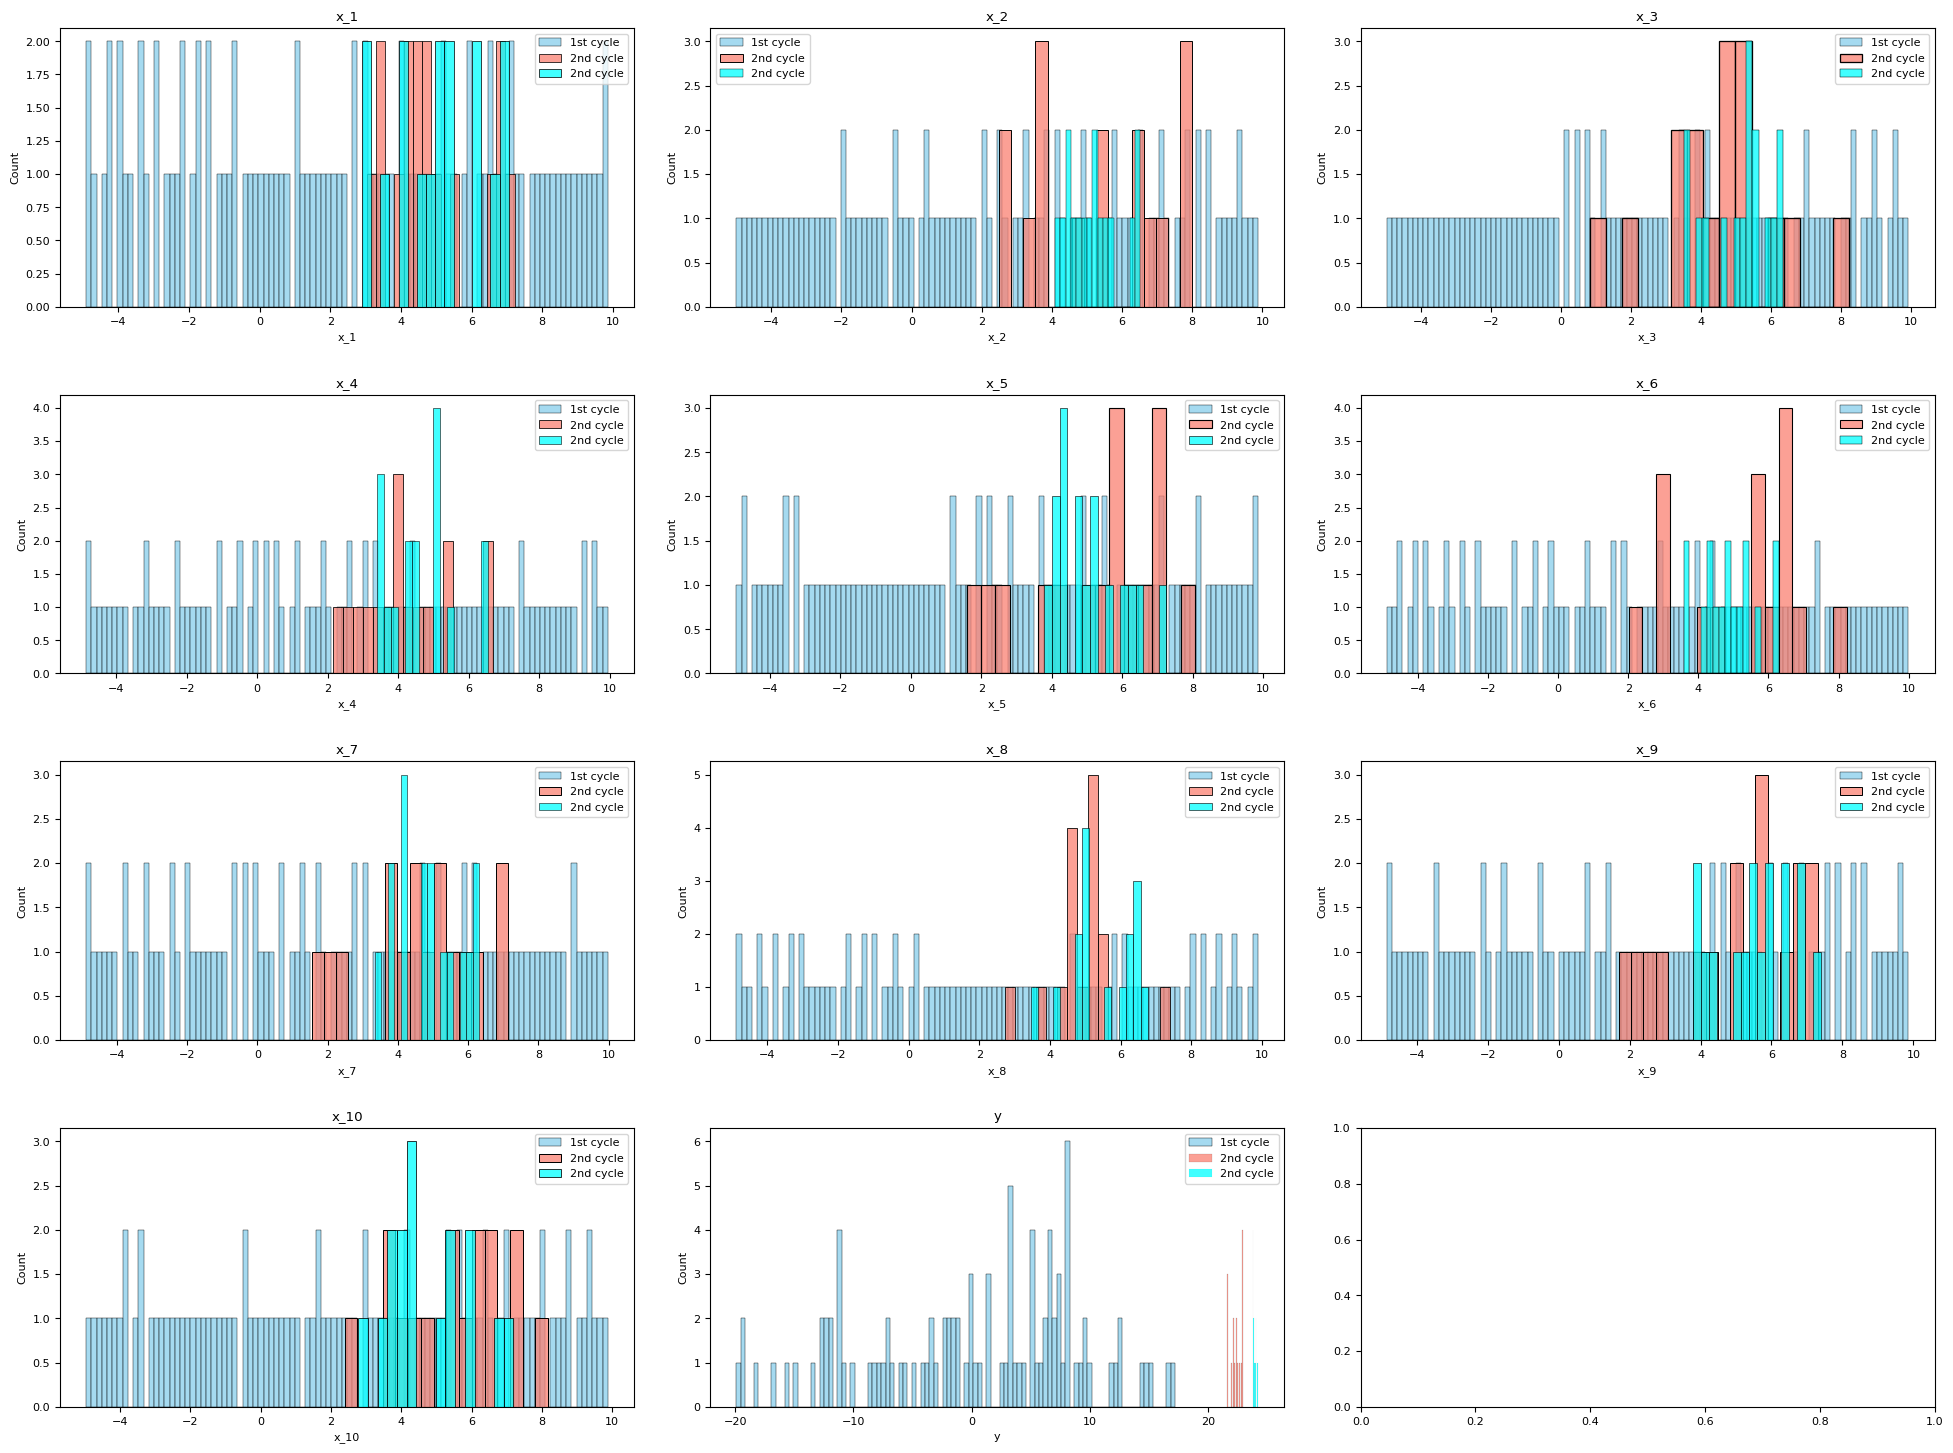

In [15]:
''' Basic data staticstics for the 2 cycles '''
print('DBTL 1st cycle')
display(data_A.describe())
print('DBTL 2nd cycle')
display(data_B.describe())
print('DBTL 3nd cycle')
display(data_C.describe())

# Plot the distribution of every column of the 2 cycles; Use 4x3 grid plot
fig, axes = plt.subplots(4, 3, figsize=(20, 15))
for i, col in enumerate(data_A.columns):
    sns.histplot(data_A[col], ax=axes[i//3, i%3], bins=len(data_A), label='1st cycle', color='skyblue')
    sns.histplot(data_B[col], ax=axes[i//3, i%3], bins=len(data_B), label='2nd cycle', color='salmon')
    sns.histplot(data_C[col], ax=axes[i//3, i%3], bins=len(data_C), label='2nd cycle', color='cyan')
    axes[i//3, i%3].set_title(col)
    axes[i//3, i%3].legend()
fig.tight_layout(pad=3.0)
plt.show()

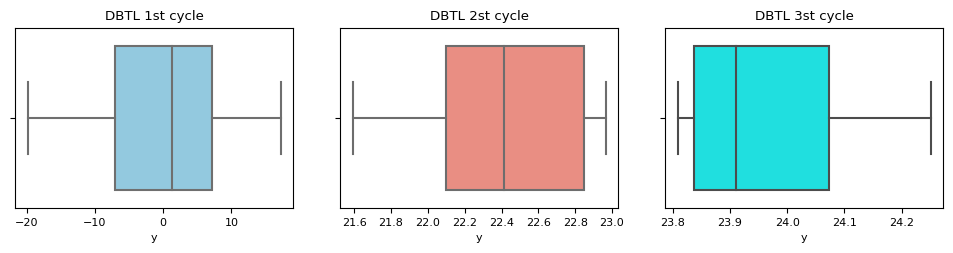

In [16]:
''' y production '''
# Boxplot of limonene production; Use 2x1 grid plot
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
sns.boxplot(data=data_A, x='y', ax=axes[0], color='skyblue')
sns.boxplot(data=data_B, x='y', ax=axes[1], color='salmon')
sns.boxplot(data=data_C, x='y', ax=axes[2], color='cyan')
axes[0].set_title('DBTL 1st cycle')
axes[1].set_title('DBTL 2st cycle')
axes[2].set_title('DBTL 3st cycle')
fig.tight_layout(pad=3.0)
plt.show()

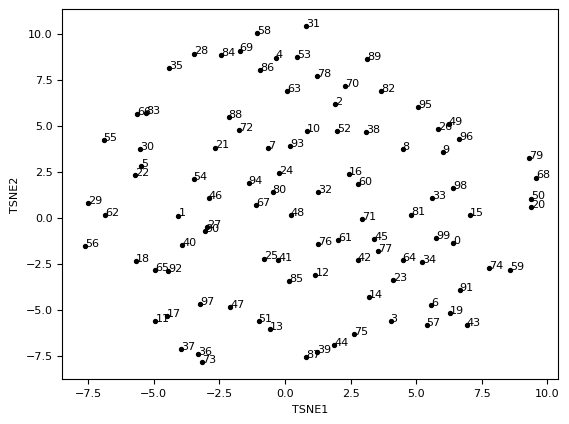

In [17]:
''' PCA and TSNE analysis '''
tsne_data_A = tsne_analysis(data_A, target_col='y', n_components=2, perplexity=20)

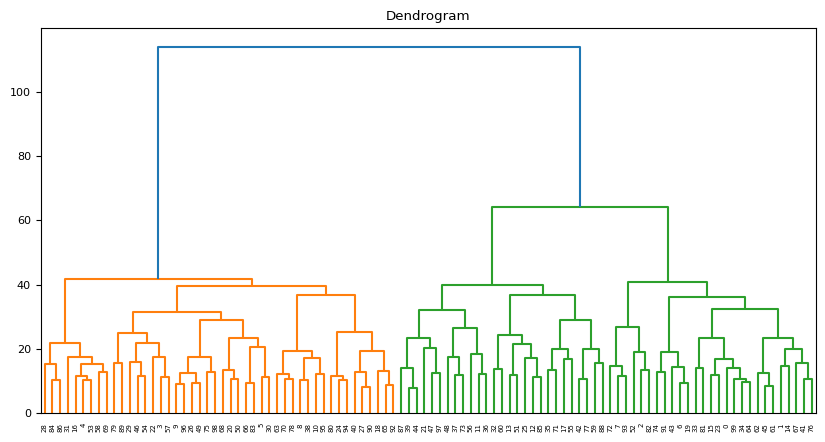

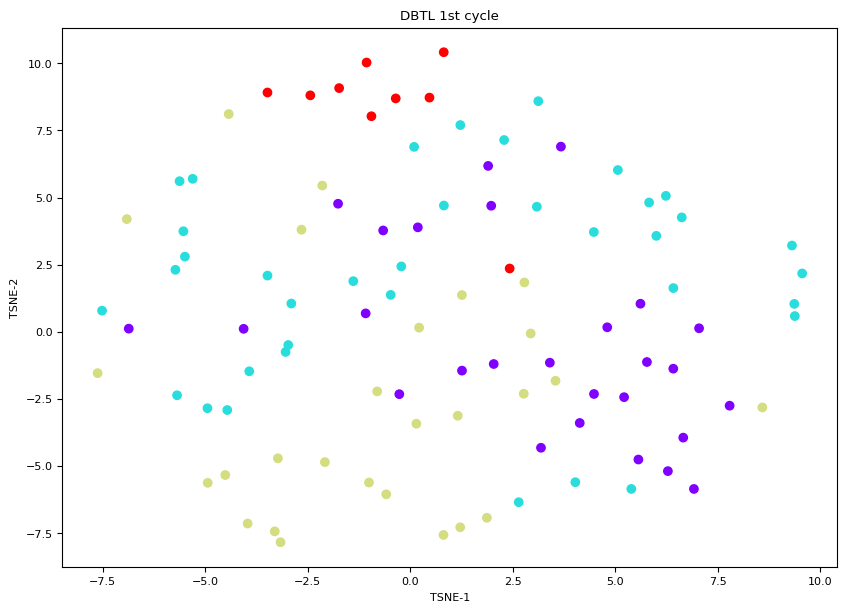

In [18]:
''' Clustering '''
# Perform hierarchical clustering on the original data using sklearn
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Plot dendrogram of the original data
plt.figure(figsize=(10, 5))
plt.title("Dendrogram")
dend = dendrogram(linkage(data_A, method='ward'))
plt.show()

# Based on Dendrogram we select 4 clusters
N_CLUSTERS = 4
# Create an instance of AgglomerativeClustering with 2 clusters
agg = AgglomerativeClustering(linkage='ward', n_clusters=N_CLUSTERS).fit(data_A)
clusters = agg.labels_
# Plot the clusters
plt.figure(figsize=(10, 7))
plt.scatter(tsne_data_A['TSNE1'], tsne_data_A['TSNE2'], c=clusters, cmap='rainbow')
plt.title('DBTL 1st cycle')
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
plt.show()

data_A['Cluster'] = clusters

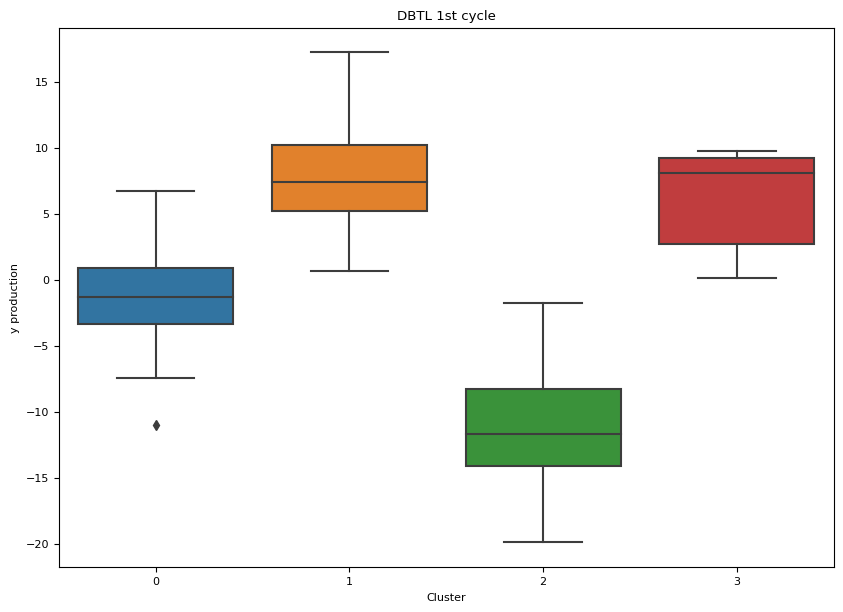

Number of instances in each cluster
2    37
3    27
0    27
1     9
Name: Cluster, dtype: int64


In [19]:
# Plot the distribution of y production for each cluster
plt.figure(figsize=(10, 7))
sns.boxplot(x='Cluster', y='y', data=data_A)
plt.title('DBTL 1st cycle')
plt.xlabel('Cluster')
plt.ylabel('y production')
plt.show()

# Change the order of the clusters based on y production
data_A['Cluster'] = data_A['Cluster'].map({0: 3, 1: 2, 2: 0, 3: 1})

# Number of instances in each cluster
print('Number of instances in each cluster')
print(data_A['Cluster'].value_counts())

# save data_A to csv
data_A.to_csv('data/ART/data_A.csv')
data_B.to_csv('data/ART/data_B.csv')
data_C.to_csv('data/ART/data_C.csv')